In [ ]:
import numpy as np
import pandas as pd
import os
import requests
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.cm import get_cmap
import seaborn as sns


#### *1. Download and Unzip in Python*


In [2]:
# URL of the file
url = 'https://github.com/dbdmg/data-science-lab/raw/master/datasets/NYC_POIs.zip'

# Define the download location (current directory)
download_path = os.path.join(os.getcwd(), 'NYC_POIs.zip')

# Download the file
print("Downloading the file...")
response = requests.get(url)
response.raise_for_status()  # Raise an exception if the download fails

# Save the file locally
with open(download_path, 'wb') as f:
    f.write(response.content)
print(f"File downloaded: {download_path}")

# Unzip the file in the current directory
print("Unzipping the file...")
with zipfile.ZipFile(download_path, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())
print("File unzipped successfully!")

# Optionally, delete the zip file after extraction
os.remove(download_path)
print("Zip file deleted.")


File downloaded: c:\Users\taha_kms\Documents\GitHub\DSE_POLITO\DSL_LAB_5\NYC_POIs.zip
Unzipping the file...
File unzipped successfully!
Zip file deleted.


---
---
# 1 & 2
---
---

#### *2. Loading the Dataset*


In [3]:
pois_df = pd.read_csv('pois_all_info', sep='\t')

nyc_municipality_df = pd.read_csv('ny_municipality_pois_id.csv', header=None, names=['id'])



C:\Users\taha_kms\AppData\Local\Temp\ipykernel_14016\1742266618.py:1: DtypeWarning: Columns (4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  pois_df = pd.read_csv('pois_all_info', sep='\t')


In [4]:
pois_df.head()

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
4,42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN


In [5]:
nyc_municipality_df.head()

,id
0,42432939
1,42448838
2,42723103
3,42764076
4,42811266


#### *3. Filter the POIs that are present in the NYC municipality dataset*

In [6]:
filtered_pois_df = pois_df[pois_df['@id'].isin(nyc_municipality_df['id'])]


filtered_pois_df.head()

,@id,@type,@lat,@lon,amenity,name,shop,public_transport,highway
0,42432939,node,40.814104,-73.949623,NaN,NaN,NaN,stop_position,NaN
1,42448838,node,40.761647,-73.949864,NaN,NaN,NaN,stop_position,NaN
2,42723103,node,40.852182,-73.772677,ferry_terminal,Hart Island Ferry Terminal,NaN,NaN,NaN
3,42764076,node,40.867164,-73.882158,NaN,Botanical Garden,NaN,stop_position,NaN
4,42811266,node,40.704806,-73.772734,NaN,NaN,NaN,stop_position,NaN


#### *4. Display the columns of dataset and their data types*

In [7]:
print("\nColumns parsed:", filtered_pois_df.columns.tolist())


print("\nData types inferred by Pandas:")
print(filtered_pois_df.dtypes)


Columns parsed: ['@id', '@type', '@lat', '@lon', 'amenity', 'name', 'shop', 'public_transport', 'highway']

Data types inferred by Pandas:
@id                   int64
@type                object
@lat                float64
@lon                float64
amenity              object
name                 object
shop                 object
public_transport     object
highway              object
dtype: object


In [8]:
filtered_pois_df.isnull().sum()


@id                     0
@type                   0
@lat                    0
@lon                    0
amenity             28824
name                22972
shop                44804
public_transport    45146
highway             45962
dtype: int64

## What did you expect?


- Since each Point of Interest (POI) can belong to only one of the four categories—amenity, shop, public_transport, or highway—it was expected that each category column would have missing values for POIs that do not belong to that category.

- Additionally, some POIs might not have a specified name, as not all points of interest are labeled (e.g., generic stop positions or unnamed locations).

---



## What can you infer from this first analysis?

- The columns @id, @type, @lat, and @lon have zero missing values, indicating that every POI has a unique identifier and geographical coordinates. This consistency is essential for mapping and spatial analysis.

- The amenity, shop, public_transport, and highway columns have significant missing values because each POI belongs to only one category. This pattern is expected and not indicative of data quality issues.

- The name column has some missing values. This might imply that certain POIs, such as generic locations like stop positions or unnamed amenities, do not have specific names. This could impact analyses that rely on named locations.

--- 

#### *3.1. Calculate POI Type Distribution*



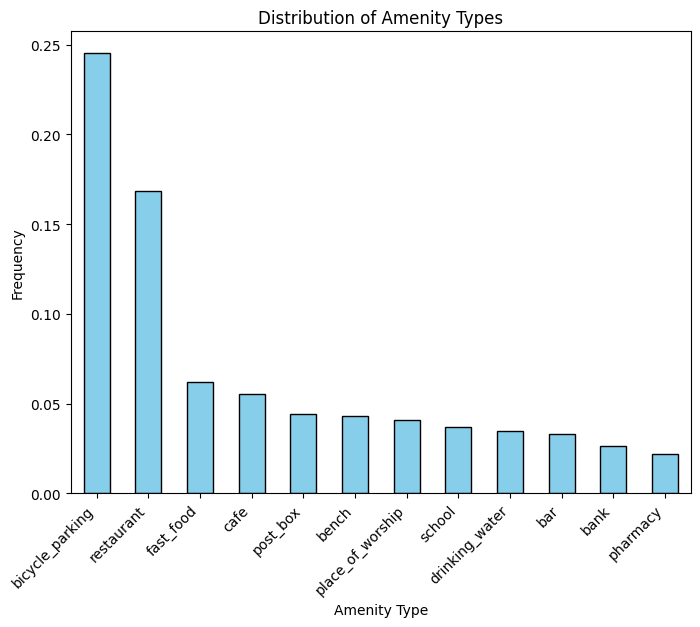

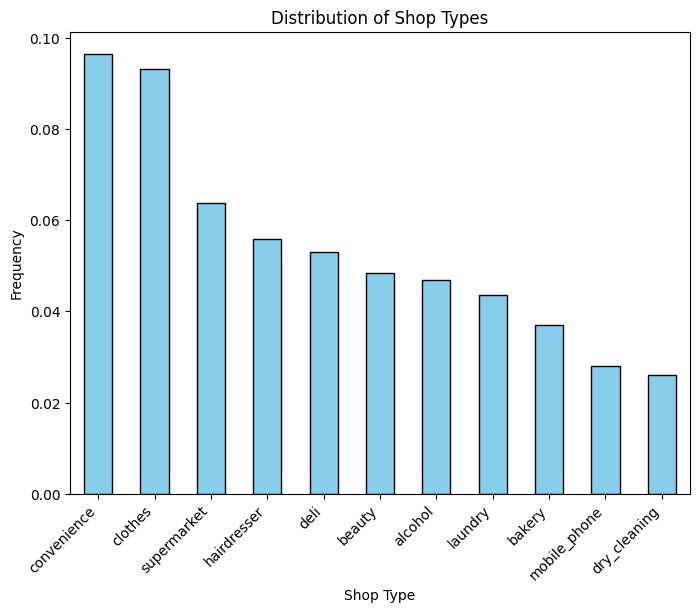

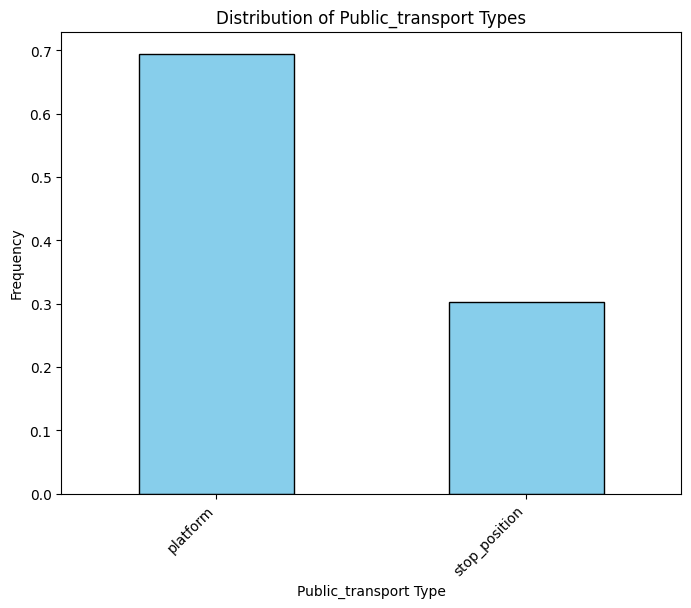

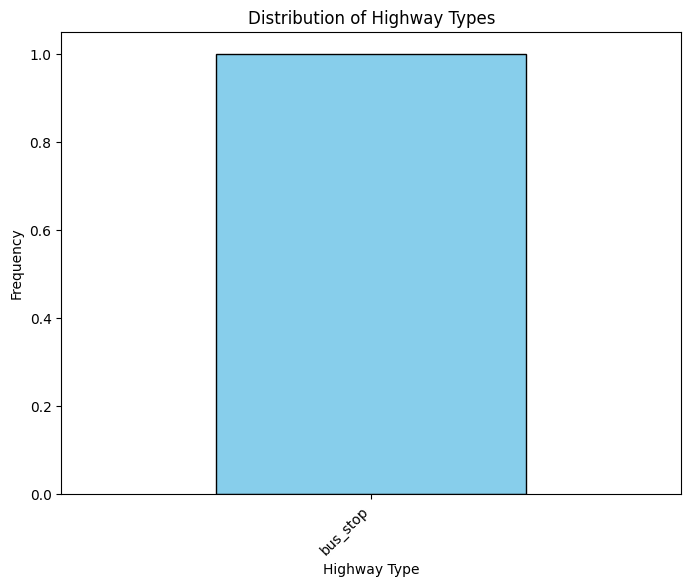

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Define a threshold for the most frequent POI types
threshold_percentage = 0.02  # Plot only POI types that exceed this percentage

# Function to plot histogram for a category
def plot_poi_distribution(df, category, threshold_percentage=0.02):
    # Drop missing values for the category
    category_df = df[category].dropna()

    # Calculate frequency
    frequency = category_df.value_counts(normalize=True)

    # Filter based on threshold
    frequency = frequency[frequency >= threshold_percentage]

    # Plot histogram
    frequency.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {category.capitalize()} Types')
    plt.xlabel(f'{category.capitalize()} Type')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Plot distributions for each category
categories = ['amenity', 'shop', 'public_transport', 'highway']
for category in categories:
    plot_poi_distribution(filtered_pois_df, category, threshold_percentage)


---
#### *6. Visualizing POIs on a New York Map*


In [ ]:
def get_top_perc(series, perc_value=.8):
    perc = series.cumsum() / series.sum()
    arg = (perc > perc_value).values.argmax()
    return series.iloc[:arg+1]


In [81]:
class Map:
    def __init__(self, df):
        """ Store Dataset with POIs information."""
        self.pois_df = df
        self.lat_min = df['@lat'].min()
        self.lat_max = df['@lat'].max()
        self.long_min = df['@lon'].min()
        self.long_max = df['@lon'].max()
        
    def plot_map(self):
        """ Display an image with NY map and return the Axes object."""
        fig, ax = plt.subplots(figsize=(8, 6))
        nyc_img = plt.imread('./New_York_City_Map.PNG')
        ax.imshow(nyc_img, zorder=0, extent=[self.long_min,
                                             self.long_max,
                                             self.lat_min,
                                             self.lat_max])

        return ax
        
    def plot_pois(self, ax, category, mask):
        """Plot data on specified Axis."""
        df = self.pois_df.loc[mask]
        
        # Version 1: using pandas
        types = df[category].unique()
        cmap = get_cmap('viridis')
        colors = cmap(np.linspace(0, 1, types.size))
        for i, t in enumerate(types):
            df_t = df.loc[df[category] == t]
            c = [colors[i]] *  df_t.shape[0]
            df_t.plot.scatter(x='@lon', y='@lat', ax=ax, c=c, alpha=.6, label=t)
        
        ax.grid(False)
        ax.set_title(f"New York City POIs: {category.capitalize()}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend(title="POI Types", loc='upper left')
        return ax

In [82]:
def show_category_on_map(df, column, perc_value):
    """
    Plot the New York map with POIs of a specific category.
    Only the top 'perc_value'% frequent types are plotted.
    """
    counts = df[column].value_counts()
    top_freq = get_top_perc(counts, perc_value)
    ny_map = Map(df)
    
    ax = ny_map.plot_map()
    mask = df[column].isin(top_freq.index)
    ny_map.plot_pois(ax, column, mask)


C:\Users\taha_kms\AppData\Local\Temp\ipykernel_14016\1367712177.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


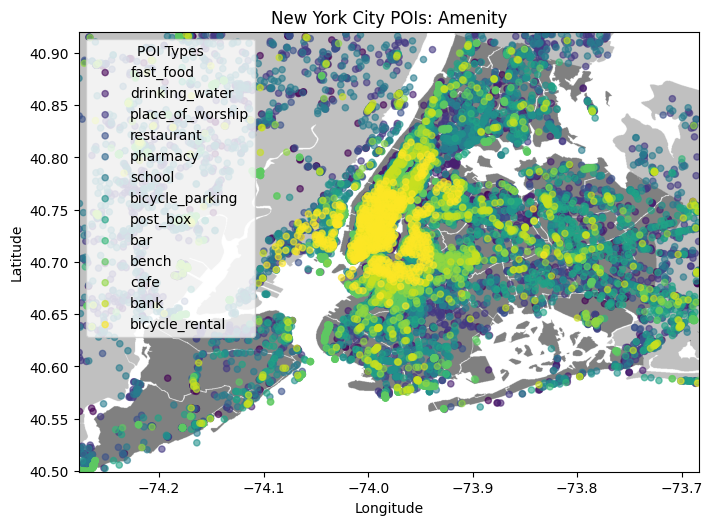

In [83]:
show_category_on_map(pois_df, 'amenity', .8)

C:\Users\taha_kms\AppData\Local\Temp\ipykernel_14016\1367712177.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


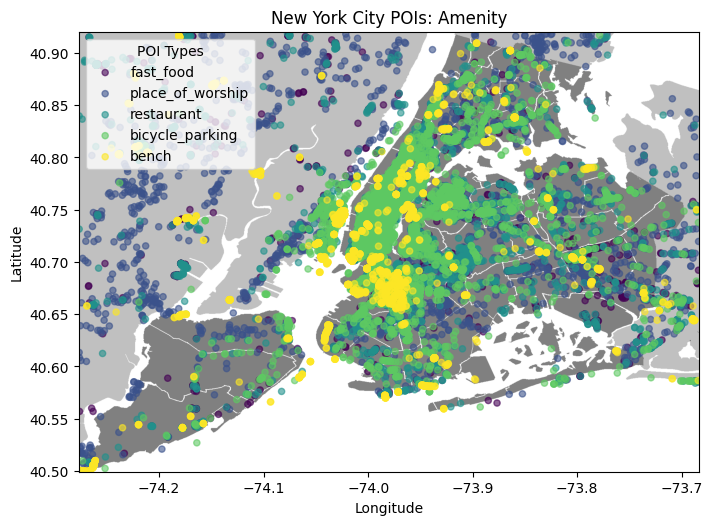

In [84]:
show_category_on_map(pois_df, 'amenity', .5)

C:\Users\taha_kms\AppData\Local\Temp\ipykernel_14016\1367712177.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


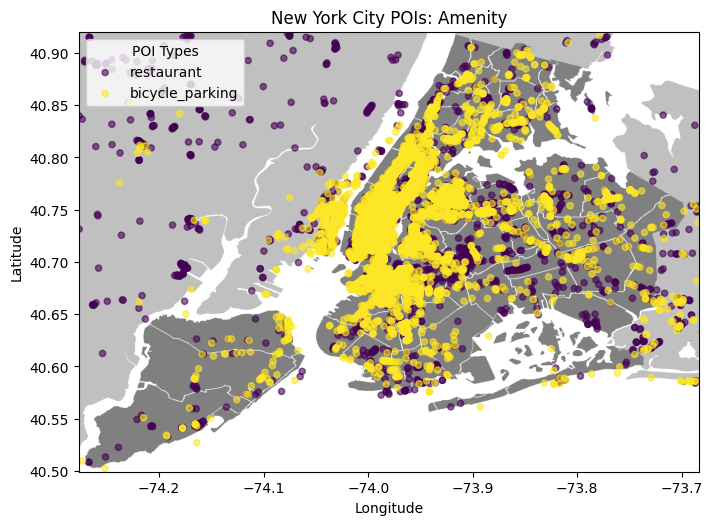

In [85]:
show_category_on_map(pois_df, 'amenity', .3)
